In [1]:
import os
import sys
import shutil

from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
sys.path.append('..')
import aeronet

# Working with raster data

In [3]:
from aeronet.dataset import BandCollection
from aeronet.dataset import RandomDataset

from aeronet.dataset.utils import parse_direcotry
from aeronet.dataset.visualization import add_mask

In [4]:
# configuration
channels = ['RED', 'GRN', 'BLU']
labels = ['100']

# parse channels in directory
SRC_PATH = './test_sample/'
band_paths = parse_direcotry(SRC_PATH, channels + labels)
bc = BandCollection(band_paths) 
bc

<BandCollection: ['GRN', 'RED', 'BLU', '100']>

# Streaming blocks of raster for prediction

In [5]:
from aeronet.dataset import SequentialSampler, SampleCollectionWindowWriter

A Jupyter Widget

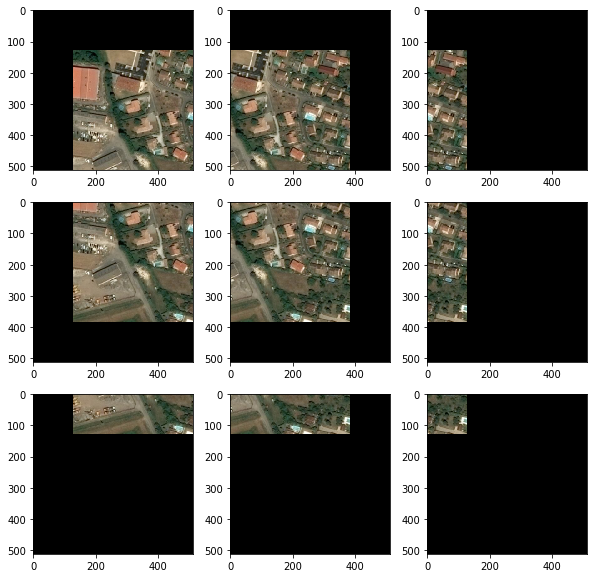

Shape of existing band (4, 512, 512)
Shape of new band (3, 512, 512)


In [6]:
BOUNDS = 128
SAMPLE_SIZE = 256, 256

src = SequentialSampler(bc, channels, SAMPLE_SIZE, BOUNDS)
dst = SampleCollectionWindowWriter('./new_sample', channels, (bc.height, bc.width), **bc.profile)

plt.figure(figsize=(10,10))

for i, (sample, block) in tqdm(enumerate(src)):
    # extract raster file
    raster = sample.numpy().transpose(1,2,0)
    
    # some manipulations with raster
    # ...
    
    # plot resulter raster
    plt.subplot(3, 3, i+1)
    plt.imshow(raster)
    
    # save to file
    dst.write(raster.transpose(2, 0, 1), **block) # write rgb

plt.show()
new_bc = dst.close()

print('Shape of existing band', bc.shape)
print('Shape of new band', new_bc.shape)

# Dataloaders for training

In [7]:
dataset = RandomDataset([bc], # list of band collections
                        sample_size=(512, 512), 
                        input_channels=channels, 
                        output_labels=labels)

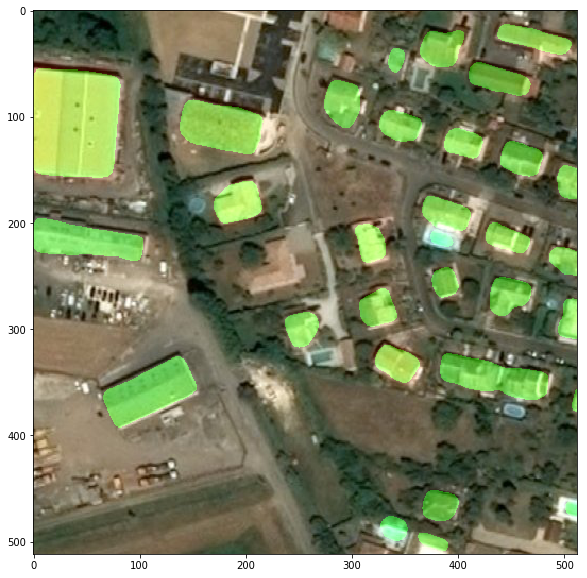

In [8]:
# get random sample
generated_sample = dataset[0]
image = generated_sample['image']
mask = generated_sample['mask']

#visualize
masked_image = add_mask(image, mask, channel='g', intensity=100)

plt.figure(figsize=(10,10))
plt.imshow(masked_image)
plt.show()

# Polygonization and rasterization

In [9]:
from aeronet.dataset import polygonize, rasterize

In [15]:
sample = bc.ordered('100')[0]

# vectorized mask
fc = polygonize(sample, epsilon=0)
fc.save('./test_sample/100.geojson')

# rasterized mask
reconstructed_sample = rasterize(fc, sample.transform, sample.shape, name='100')

../aeronet/dataset/vector/feature.py:43: RasterioDeprecationWarning: Comparison to str will be removed in 1.0
  if self.crs != CRS_LATLON:


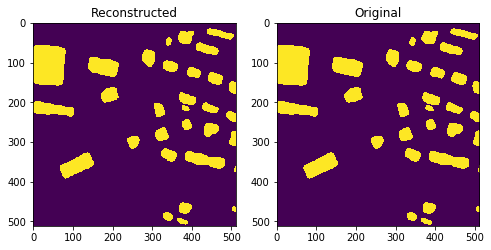

In [14]:
# visualiziation
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(reconstructed_sample.numpy().squeeze())
plt.title('Reconstructed')
plt.subplot(122)
plt.imshow(sample.numpy().squeeze())
plt.title('Original')
plt.show()

# Working with vector data

In [16]:
from aeronet.dataset.vector import Feature, FeatureCollection

In [17]:
fc = FeatureCollection.read('./test_sample/100.geojson')

feature = fc.features[0]

CRS: EPSG:4326
Properties: {}


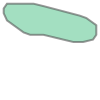

In [18]:
feature

In [19]:
# GoeJSON-like represenation
feature.geojson

{'geometry': {'coordinates': (((1.4440453809144207, 43.67236026968497),
    (1.4440400170054402, 43.67235251025002),
    (1.4440400170054402, 43.672344750814084),
    (1.4440453809144207, 43.672333111658276),
    (1.4440722004593234, 43.672313713060234),
    (1.4440829282772842, 43.672309833339874),
    (1.4441043839132064, 43.672309833339874),
    (1.4441526590940312, 43.672298194177294),
    (1.4441687508209726, 43.672298194177294),
    (1.4441848425479142, 43.6723020738984),
    (1.444190206456895, 43.672309833339874),
    (1.444190206456895, 43.67232535221981),
    (1.4441741147299534, 43.67233699137713),
    (1.4441633869119923, 43.67234087109573),
    (1.4441043839132064, 43.67235638996763),
    (1.444088292186265, 43.67236026968497),
    (1.4440453809144207, 43.67236026968497)),),
  'type': 'Polygon'},
 'properties': {},
 'type': 'Feature'}

#### reprojected to EPSG:3857

CRS: EPSG:3857
Properties: {}


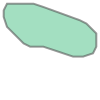

In [20]:
feature.reproject('EPSG:3857')

In [23]:
feature.reproject('EPSG:3857').geometry

{'coordinates': (((160750.39648577213, 5414878.388509652),
   (160749.79937815573, 5414877.19429442),
   (160749.79937815573, 5414876.000079188),
   (160750.39648577213, 5414874.208756338),
   (160753.38202385398, 5414871.223218258),
   (160754.57623908672, 5414870.626110639),
   (160756.96466955222, 5414870.626110639),
   (160762.33863809958, 5414868.83478779),
   (160764.1299609487, 5414868.83478779),
   (160765.9212837978, 5414869.431895405),
   (160766.5183914142, 5414870.626110639),
   (160766.5183914142, 5414873.0145411035),
   (160764.7270685651, 5414874.805863957),
   (160763.53285333235, 5414875.402971569),
   (160756.96466955222, 5414877.791402036),
   (160755.17334670312, 5414878.388509652),
   (160750.39648577213, 5414878.388509652)),),
 'type': 'Polygon'}